# Volatility and Sharpe Ratio Estimates based on Daily vs. Monthly Data

This note demonstrates the difference in Volatility/Sharpe ratios based on daily and monthly data

1. Assets: State Street SPDR U.S. sector ETF's
2. Period: 2012/02/01 to 2022/01/31, 10 years
3. Data source: Alpha Vantage (close price, AV starts to charge adjusted close price data since 2022)

### Observation summary
1. Monthly annualized volatility estimates are generally lower than daily annualized volatility <br> 
(This behavior is showed on both the recent fixed 10-year period and 3-year rolling window, see plots below)
2. Both monthly and daily return data exhibits negative auto-correlation (see ACF plots and AR(1)-coeffs)
3. Auto-correlation of monthly data has larger absolutely value than the auto-correlation of daily data
4. This implies that there is some intra-month mean reversion in these sector ETF's
5. Applying AR(p=1) model, the resulting adjusted volatility based on residuals have a smaller gap between daily and monthly estimates 
6. Randomly generated i.i.d. return data has no such issue. 

In [1]:
import os
import collections

import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
%run sharpe  # Python script for this notebook 

## DATA: SP500 ETF and U.S. Sector ETFs

In [3]:
# ETF information 
info = get_sector_etf_info().reset_index(drop=True)
row_bench = pd.DataFrame([{'Ticker': 'SPY', 'Name': 'S&P 500'}])
info = pd.concat([row_bench, info]).reset_index(drop=True)

tix2name = {k: '{} ({})'.format(k, v) for k, v in info.set_index('Ticker')['Name'].items()}
tickers = info['Ticker'].tolist()

info

,Ticker,Name
0,SPY,S&P 500
1,XLE,Energy
2,XLB,Materials
3,XLI,Industrial
4,XLY,Consumer Discretionary
5,XLP,Consumer Staples
6,XLV,Health Care
7,XLF,Financials
8,XLK,Information Technology
9,XLU,Utilities


,SPY,XLE,XLB,XLI,XLY,XLP,XLV,XLF,XLK,XLU
Date,,,,,,,,,,
2012-02-01,132.47,70.97,37.55,36.61,41.46,32.26,36.15,14.28,27.30,34.80
2012-02-02,132.68,71.51,37.37,36.63,41.41,32.38,36.01,14.35,27.37,34.74
2022-01-28,441.95,65.63,83.22,99.70,178.10,75.68,130.48,38.72,158.00,67.96
2022-01-31,449.91,65.92,84.45,100.74,184.95,75.97,131.23,39.06,161.97,69.25


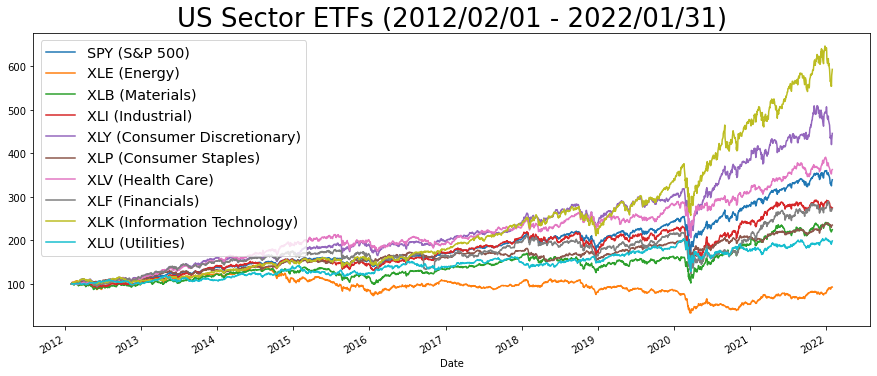

In [4]:
# Load data 
# start = pd.to_datetime('1999/11/01')  # inception
# start = pd.to_datetime('2002/02/01') # 20 years
start = pd.to_datetime('2012/02/01') # 10 years
end = pd.to_datetime('2022/01/31')

df_close = get_ts(tickers, item='close', start=start, end=end)  # As 2022, adjusted_close no longer free

# Plot 
plot_normalized_ts(df_close, title='US Sector ETFs', start=start, end=end, rename=tix2name, figsize=(15,6))

# Display close ETF price
pd.concat([df_close.head(2), df_close.tail(2)])

## Sharpe Ratio and Annualized Volatility Estimates Comparison  
1. Based on daily data
2. Based on monthly data

In [5]:
df_stats = compute_performance_stats_dm(df_close)
df_stats.rename(index=tix2name, inplace=True)

cols_pct = [(x, y) for x in ['Return', 'Volatility'] for y in ['Daily', 'Monthly']]
cols_dec = [('Sharpe', y) for y in ['Daily', 'Monthly']]
cols = cols_pct + cols_dec

fmt = {x: '{:.1%}' for x in cols_pct}
fmt.update({x: '{:.2f}' for x in cols_dec})
df_stats[cols].style.format(formatter=fmt)

## Rolling 3-year Realized Volatility (dotted line is monthly estimates)

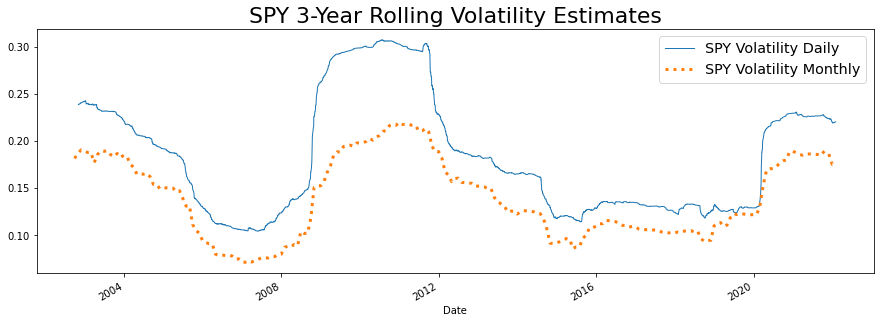

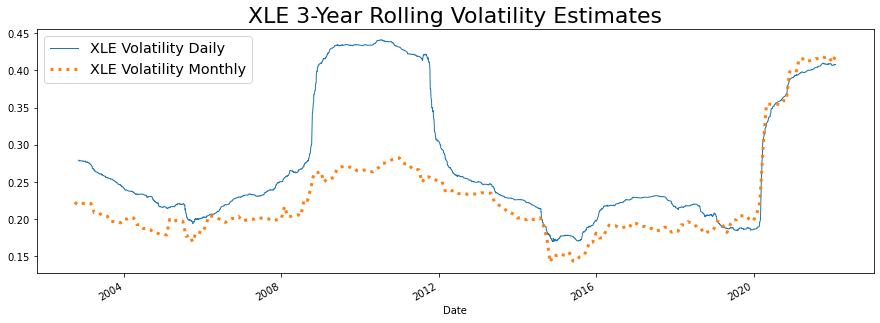

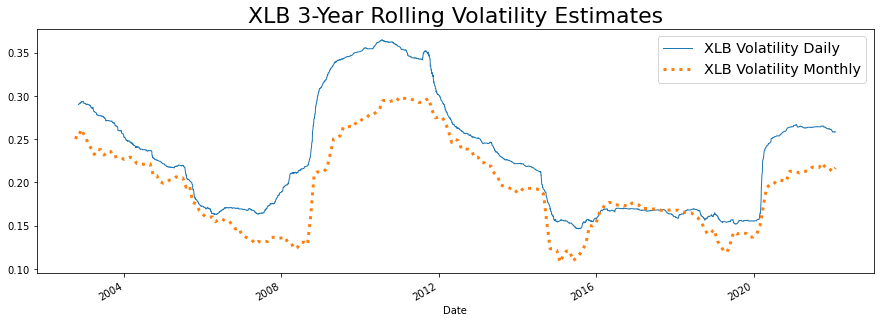

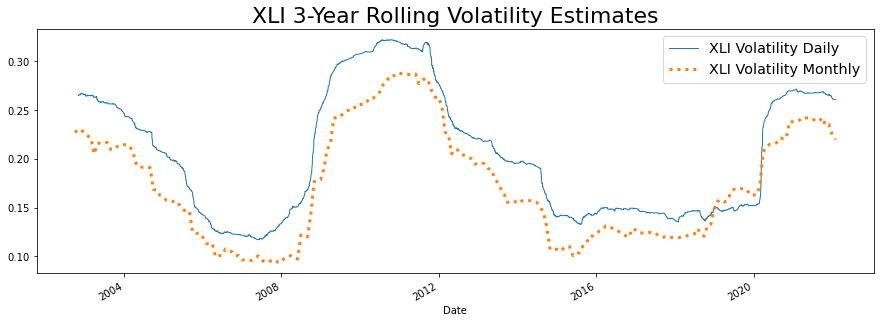

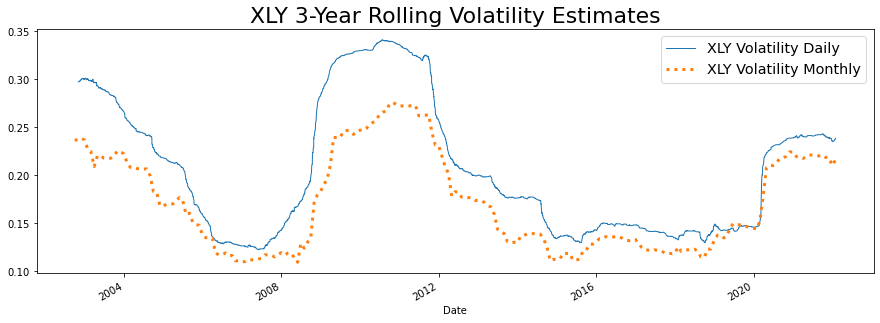

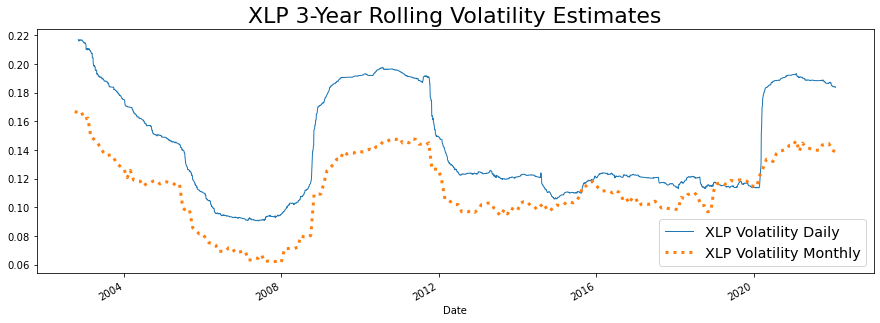

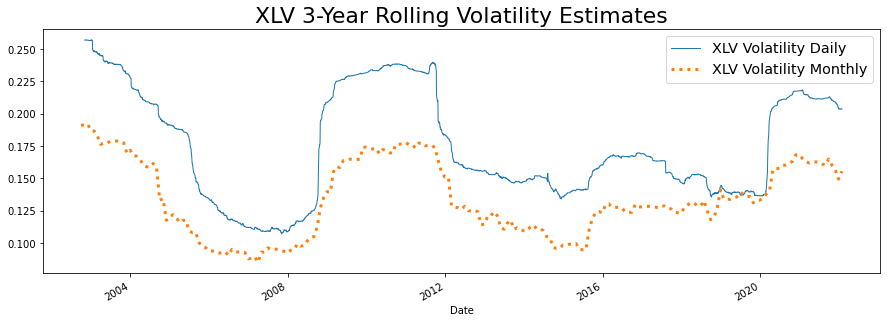

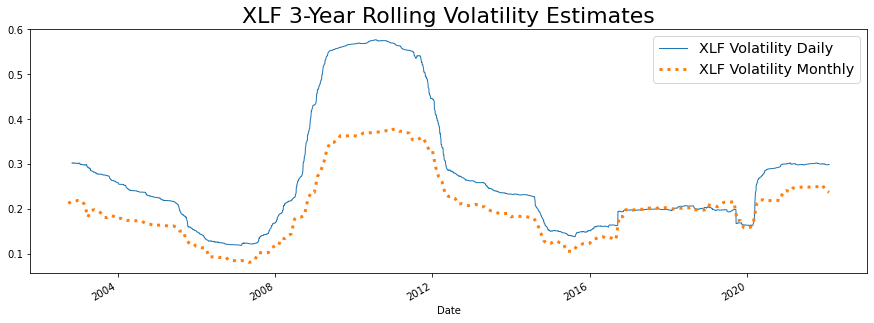

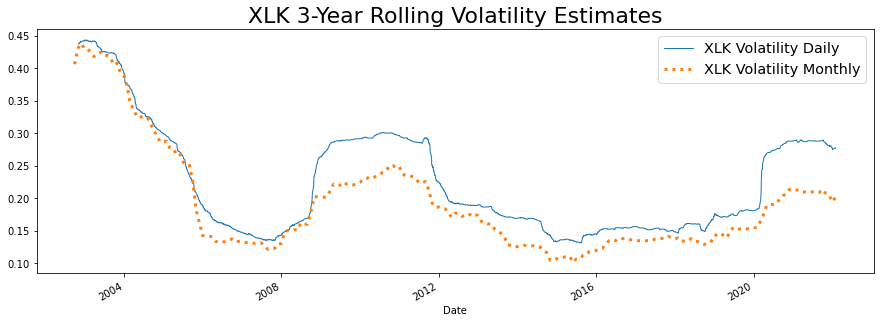

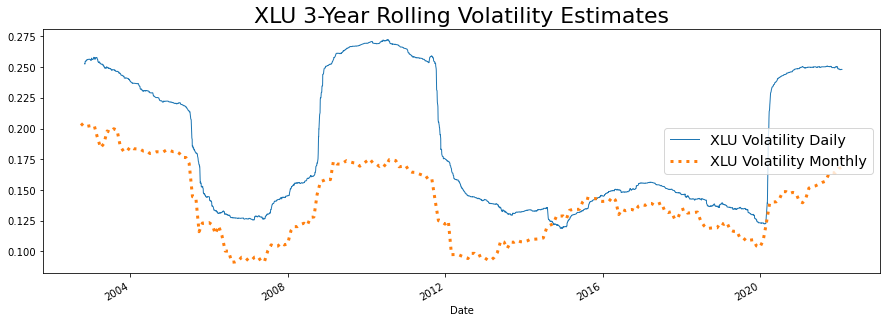

In [6]:
full_price = get_ts(tickers, item='close', start=None, end=end)  # As 2022, adjusted_close no longer free

figs = plot_rolling_volatility(full_price, num_years=3)

## Adjusted Volatility Estimate by AR(p=1) model
AR(1) Volatility = Residual Volatility / ( 1 - AR1 Coeff^2 )

AR(1) shortens the gap between annualized volatility estimates between daily and monthly data to some extent. 

In [7]:
ar_stats = run_ar_models_dm(df_close)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [8]:
df_vol = pd.concat([df_stats[['Volatility']], ar_stats[['AR_Vol']].rename(index=tix2name)], axis=1)
df_vol.style.format('{:.1%}')

## Auto-correlation

Running AR(1)-model on both monthly and daily return data, both have negative AR(1)-coefficient. (see column *AR1_Coeff*)

Monthly data has a larger magnitude, except *XLF* Financial and *XLK* Information Technology. 

Negative auto-correlation implies there is some intra-month mean reversion in price data. 

In [9]:
cols_pct = [(x, y) for x in ['AR_Vol', 'Sigma_Vol'] for y in ['Daily', 'Monthly']]
cols_dec = [('AR1_Coeff', y) for y in ['Daily', 'Monthly']]

fmt = {x: '{:.1%}' for x in cols_pct}
fmt.update({x: '{:.2f}' for x in cols_dec})
ar_stats.rename(index=tix2name).style.format(formatter=fmt)

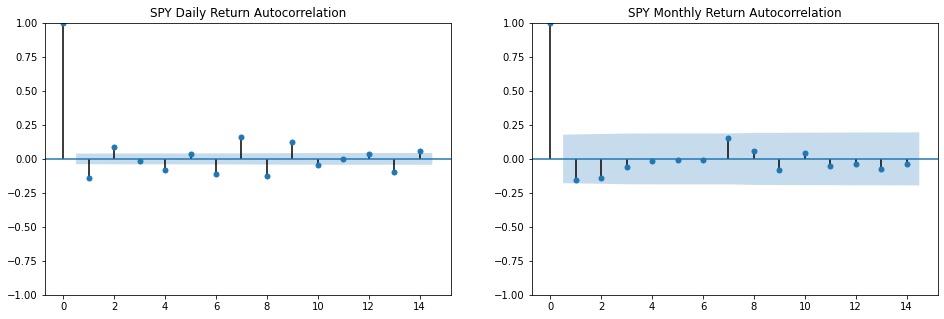

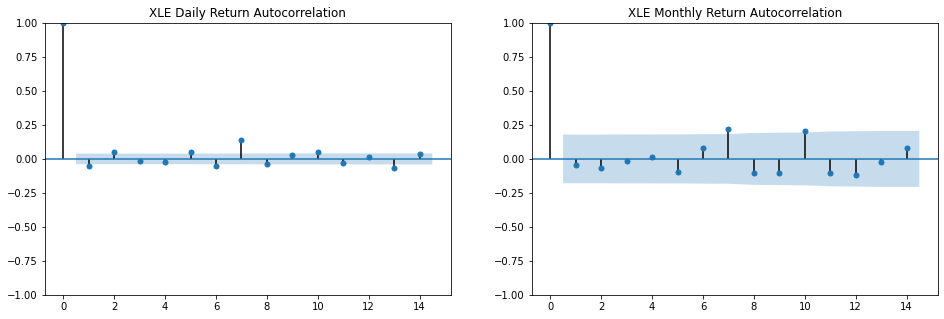

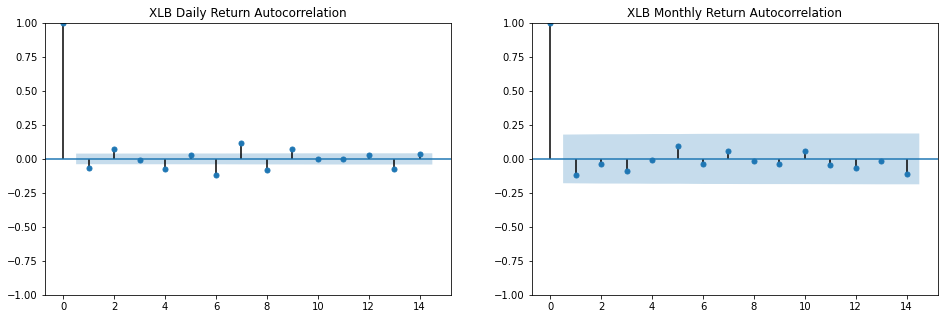

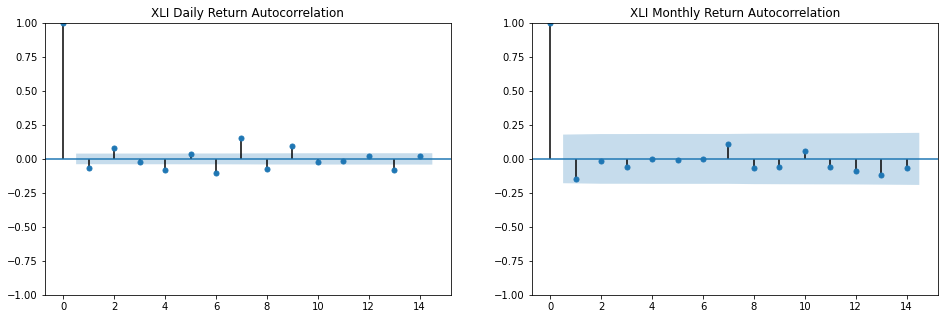

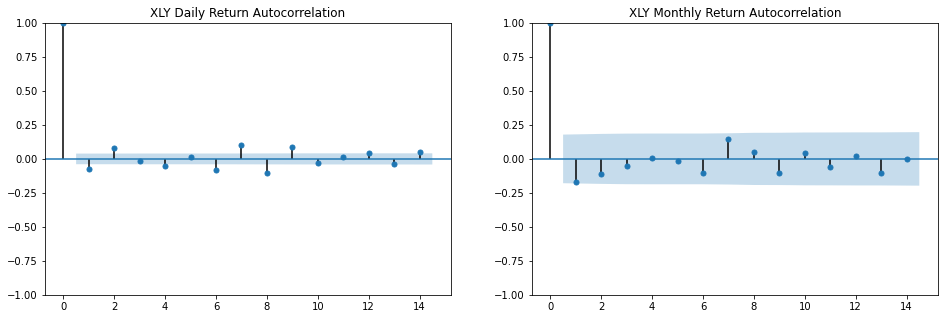

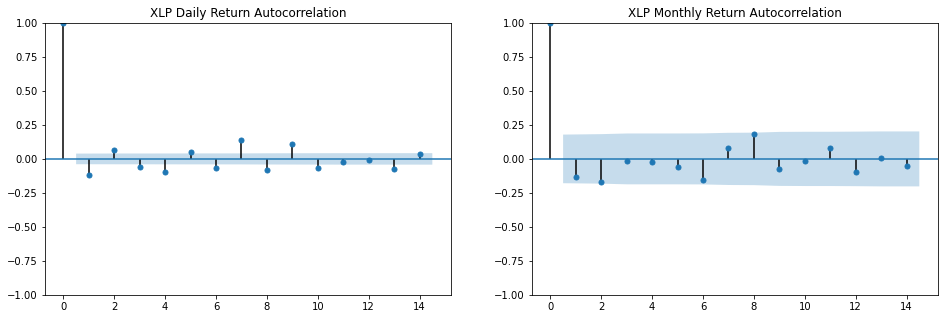

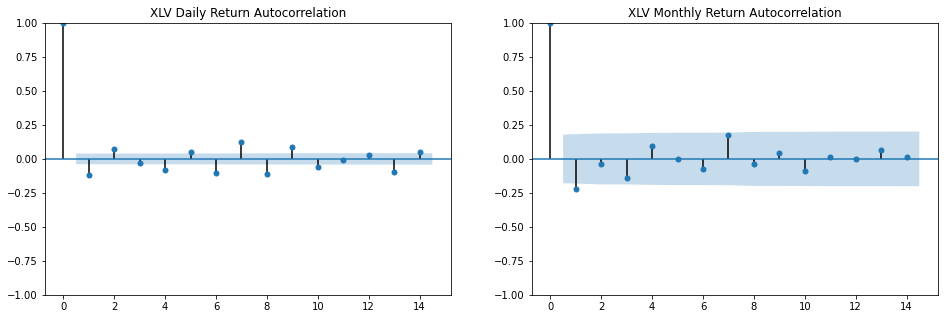

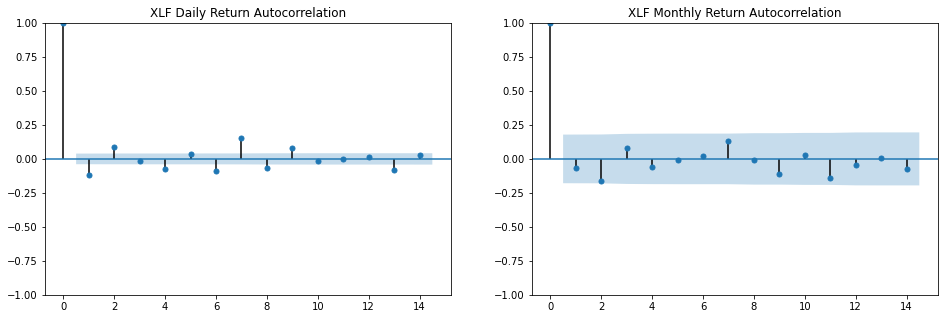

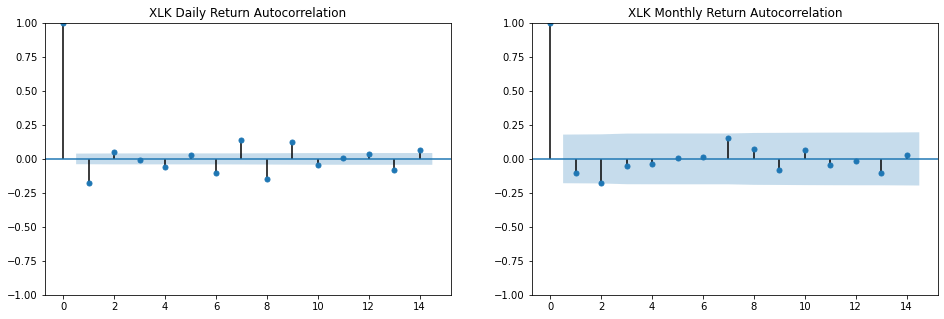

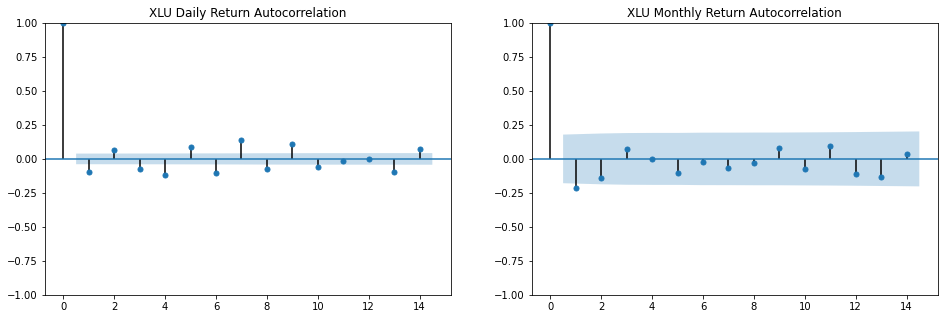

In [10]:
# Auto-Correlation Plots 
figs = plot_acf_dm(df_close)

## Randomly generated i.i.d. time-series data 
no auto-correlation, daily volatility estimates are close to monthly estimates

In [11]:
%run sharpe

<Figure size 432x288 with 0 Axes>

        Fake Target Volatility
Fake 1                    0.21
Fake 2                    0.17
Fake 3                    0.20
Fake 4                    0.22
Fake 5                    0.23
Fake 6                    0.17


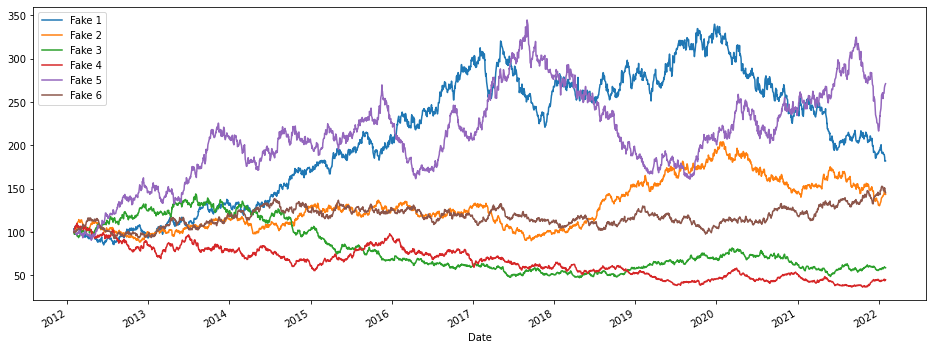

In [12]:
daily_fake_price = fake_iid_ts_data(n=6, dates=df_close.index)

daily_fake_price.plot(figsize=(16,6))

In [13]:
df_stats = compute_performance_stats_dm(daily_fake_price)

cols_pct = [(x, y) for x in ['Return', 'Volatility'] for y in ['Daily', 'Monthly']]
cols_dec = [('Sharpe', y) for y in ['Daily', 'Monthly']]
cols = cols_pct + cols_dec

print('Performance stats of fake i.i.d. time-series data.')

fmt = {x: '{:.1%}' for x in cols_pct}
fmt.update({x: '{:.2f}' for x in cols_dec})
df_stats[cols].style.format(formatter=fmt)

Performance stats of fake i.i.d. time-series data.


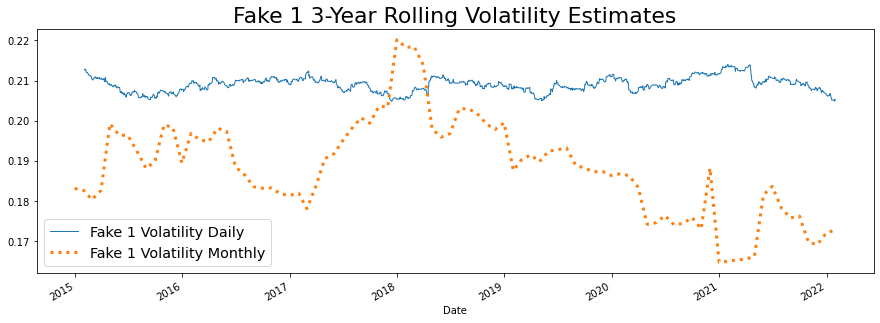

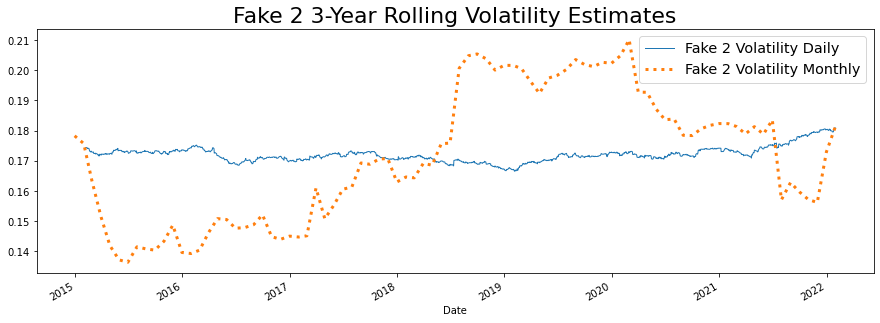

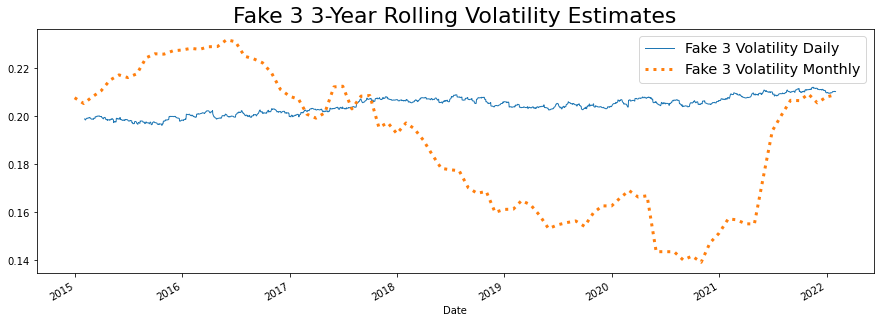

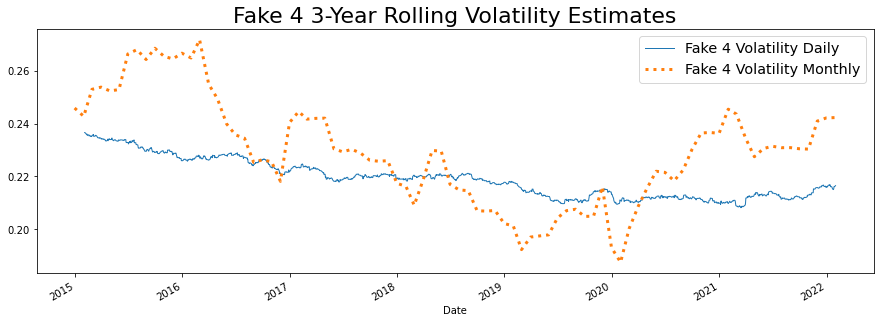

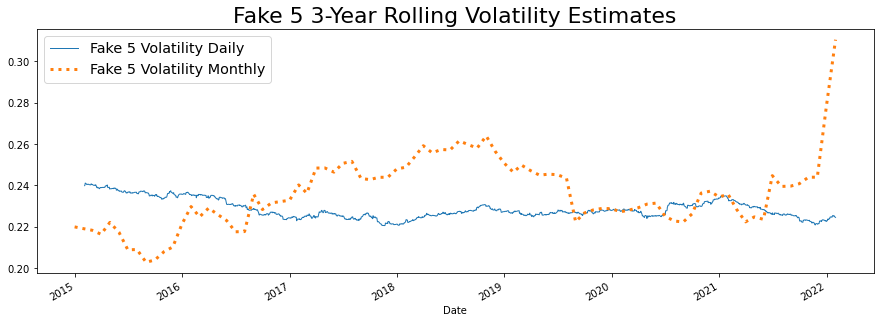

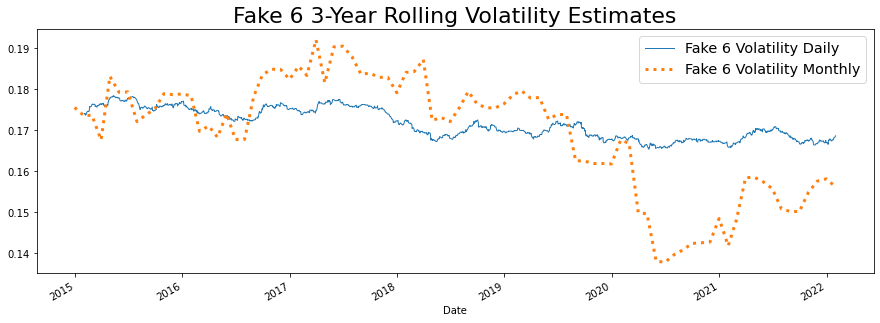

In [14]:
figs = plot_rolling_volatility(daily_fake_price)

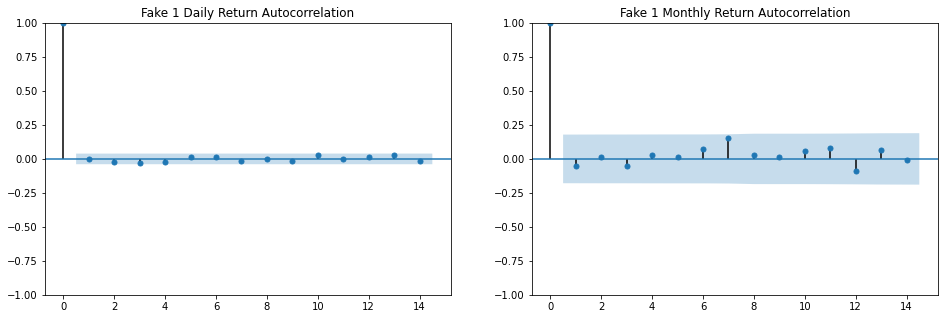

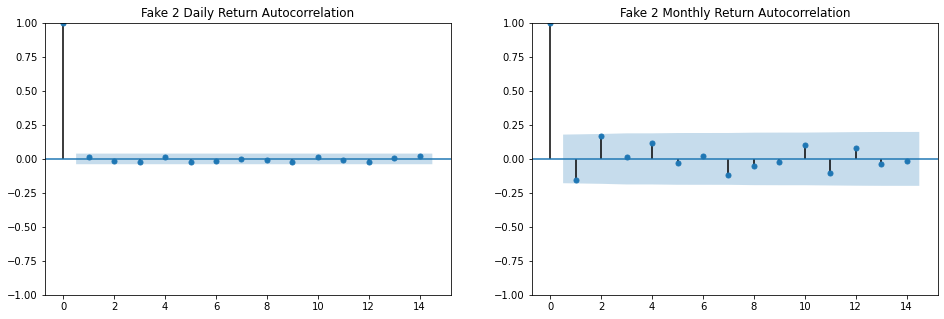

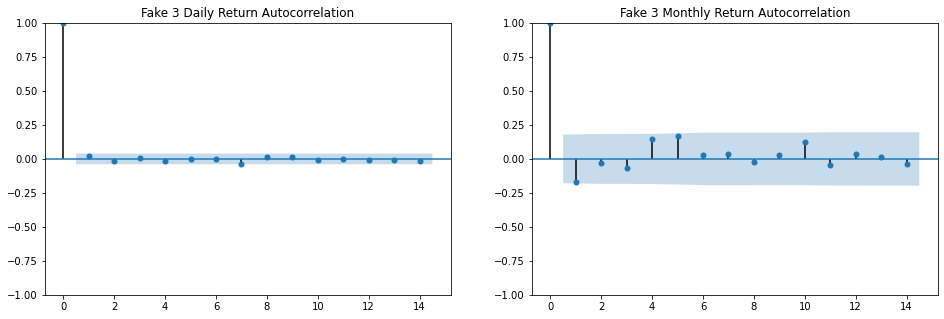

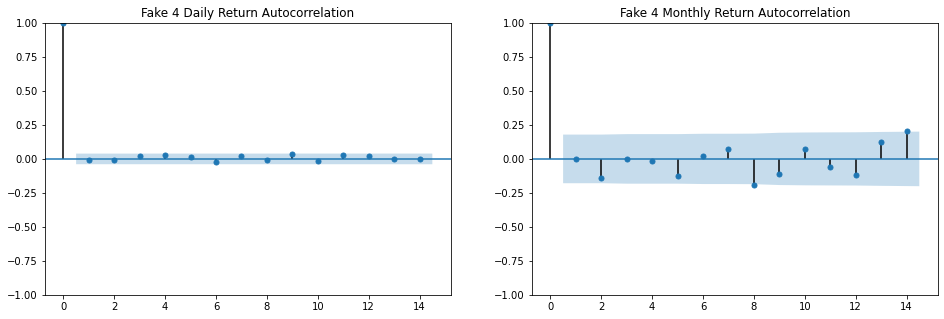

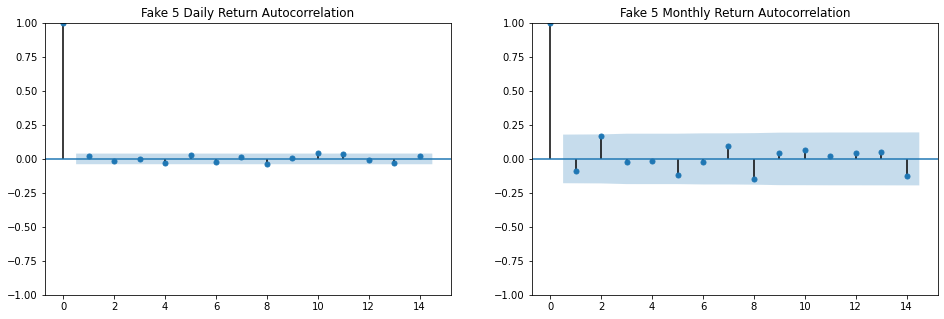

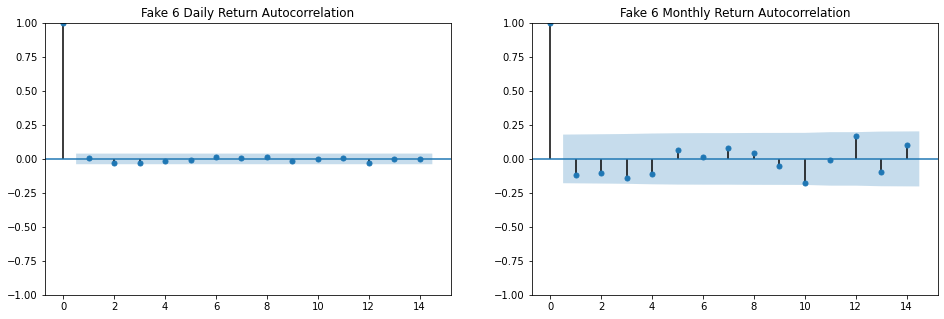

In [15]:
figs = plot_acf_dm(daily_fake_price)

In [16]:
'Last Update = {}'.format(datetime.datetime.now())

'Last Update = 2022-02-07 15:18:13.048542'